In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

In [2]:
def refining_prediction(y_pred): 
    y_pred = np.round(y_pred, 0)
    y_pred[y_pred < 0] = 0
    return y_pred
    
refining_prediction([.99, -99, 0, 1.5, 1.1])

array([1., 0., 0., 2., 1.])

## Reading / Displaying the Data 

In [3]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp12.csv')

In [4]:
df_dataset_v2.describe()

,month,unit_price,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,6.341538,236.499676,116.636923,0.836154,0.013077,0.018462,0.016154,0.018462,0.018462,0.006154,...,0.010769,0.005385,0.008462,0.064615,0.018462,0.018462,0.006154,0.008462,0.010000,0.013077
std,3.596290,216.022433,241.937405,0.370278,0.113648,0.134665,0.126116,0.134665,0.134665,0.078235,...,0.103254,0.073210,0.091632,0.245941,0.134665,0.134665,0.078235,0.091632,0.099537,0.113648
min,1.000000,6.910000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,113.246433,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,175.776013,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,288.258913,98.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1903.950000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_dataset_v2.head()

,code,year_month,month,unit_price,prod_code,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,205.618941,0671c2b9132a3f5215a4212ce0691694,664,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,245.817299,0671c2b9132a3f5215a4212ce0691694,225,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,216.730145,0671c2b9132a3f5215a4212ce0691694,211,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,206.905313,0671c2b9132a3f5215a4212ce0691694,634,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,199.342329,0671c2b9132a3f5215a4212ce0691694,1343,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y', 'prod_code'] and 'hc_cluster' not in c]

In [7]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [8]:
X_cols

['code',
 'month',
 'unit_price',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [9]:
df_dataset_v2[X_cols].head()

,code,month,unit_price,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,205.618941,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,245.817299,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,216.730145,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,206.905313,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,199.342329,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [10]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [11]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [12]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [13]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=0)
regressors['gbm'] = gbm

In [14]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE, verbose=0)
regressors['gbm_q'] = gbm_q

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [16]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [17]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

## Building a Train Test set to Use on gridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [19]:
df_set = df_train_val_test[(df_train_val_test.set == 6)]
train_years = parse_str_list(df_set.train.values[0])
val_years = parse_str_list(df_set.val.values[0])
df_set

,set,train,val,reserved
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


In [20]:
df_dataset_v2['split'] = 0
df_dataset_v2.loc[df_dataset_v2.year_month.isin(val_years),'split'] = -1

In [21]:
df_dataset_v2[['year_month','split']].sort_values('year_month')

,year_month,split
205,2016-06,0
794,2016-06,0
255,2016-06,0
334,2016-06,0
602,2016-06,0
...,...,...
949,2017-05,-1
1187,2017-05,-1
479,2017-05,-1
155,2017-05,-1


In [22]:
cv = PredefinedSplit(test_fold=df_dataset_v2['split'])

In [23]:
x_scaler = MinMaxScaler()
transform_cols = list(set(X_cols) - set(['month', 'code']))
x_scaler.fit(df_dataset_v2.loc[df_dataset_v2.split == 0, transform_cols])
df_dataset_transformed = df_dataset_v2.copy()
df_dataset_transformed[transform_cols] = x_scaler.transform(df_dataset_transformed[transform_cols])
x_scaler.n_features_in_, len(transform_cols)

(21, 21)

In [24]:
df_dataset_transformed

,code,year_month,month,unit_price,prod_code,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10,split
0,0,2016-11,11,0.104673,0671c2b9132a3f5215a4212ce0691694,664,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,2016-12,12,0.125865,0671c2b9132a3f5215a4212ce0691694,225,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,2017-01,1,0.110531,0671c2b9132a3f5215a4212ce0691694,211,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,2017-02,2,0.105352,0671c2b9132a3f5215a4212ce0691694,634,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,2017-03,3,0.101364,0671c2b9132a3f5215a4212ce0691694,1343,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,129,2017-01,1,0.106564,ffdad3ddbaf6c76c9bba1b48c51e03c6,133,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1296,129,2017-02,2,0.107624,ffdad3ddbaf6c76c9bba1b48c51e03c6,44,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1297,129,2017-03,3,0.107893,ffdad3ddbaf6c76c9bba1b48c51e03c6,65,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1298,129,2017-04,4,0.097588,ffdad3ddbaf6c76c9bba1b48c51e03c6,76,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


* https://github.com/Microsoft/LightGBM/issues/1339
* https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9

In [25]:
regressors['gbm_q'].get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'alpha', 'metric', 'verbose'])

In [26]:
regressors['gbm'].get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'verbose'])

In [27]:
results = []
r_dict = {}
for r_name, r in regressors.items():

    param_grid = {
        'num_leaves': [10, 20, 30, 50],
        'n_estimators': [100, 200, 500],
        'min_child_samples': [10, 20, 30, 50],
        'max_depth': [9, 13, 15, 21],
        'learning_rate': [0.1],
        'verbose':[-1], 
        'metric':['mape', 'mae']

        }

    gsearch = GridSearchCV(estimator=r, param_grid=param_grid, cv=cv, verbose=0)
    r_inst = gsearch.fit(X=df_dataset_transformed[X_cols], y=df_dataset_transformed.Y, verbose=0)

    r_dict[r_name] = r_inst

    print(r_inst.best_params_, r_inst.best_score_)


{'learning_rate': 0.1, 'max_depth': 9, 'metric': 'mape', 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 10, 'verbose': -1} 0.6199912685884039
{'learning_rate': 0.1, 'max_depth': 21, 'metric': 'mape', 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 30, 'verbose': -1} 0.42202972512032644


In [28]:
metric_list = []

In [29]:
r_inst.best_estimator_

LGBMRegressor(alpha=0.5, max_depth=21, metric='mape', min_child_samples=10,
              n_estimators=500, num_leaves=30, objective='quantile',
              random_state=42, verbose=-1)

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 142.2572
MAPE': 2.2168
MDAPE': 0.9039
MSE: 20237.1040
MAE: 65.0720
R2: 0.6400


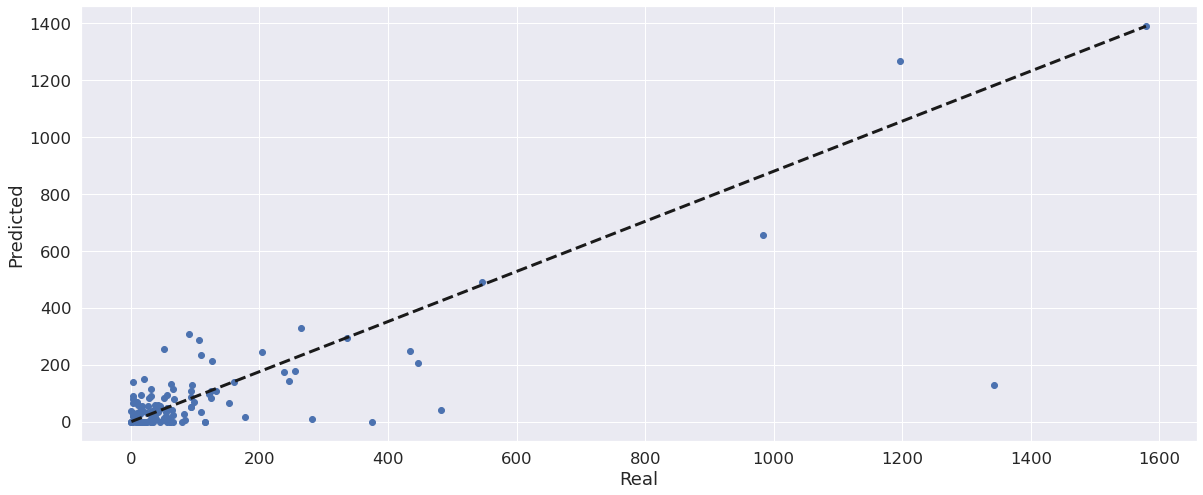

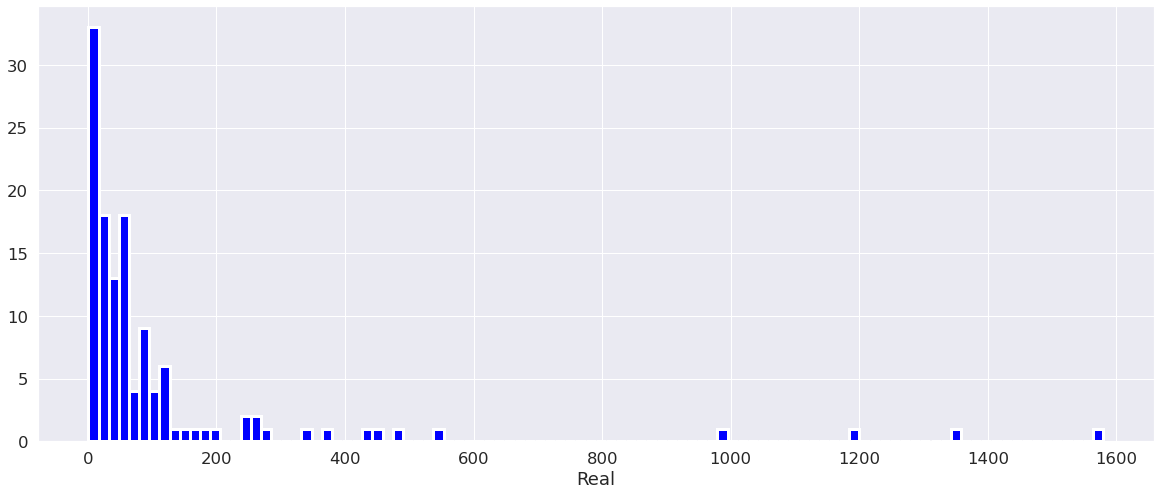

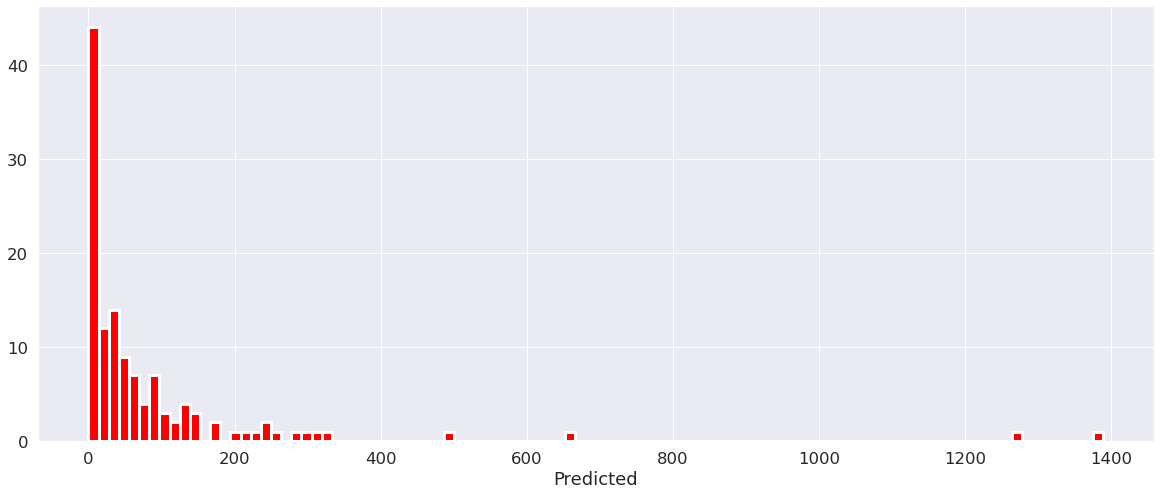


Validating gbm on set 6 and 2017-04
932 122
RMSE : 110.2013
MAPE': 1.7693
MDAPE': 0.8600
MSE: 12144.3197
MAE: 61.0738
R2: 0.7517


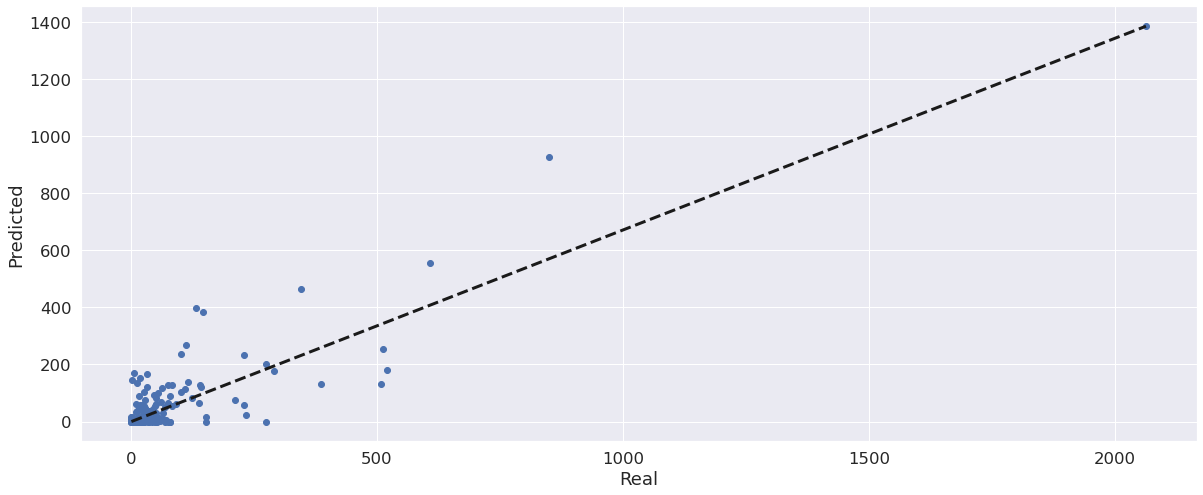

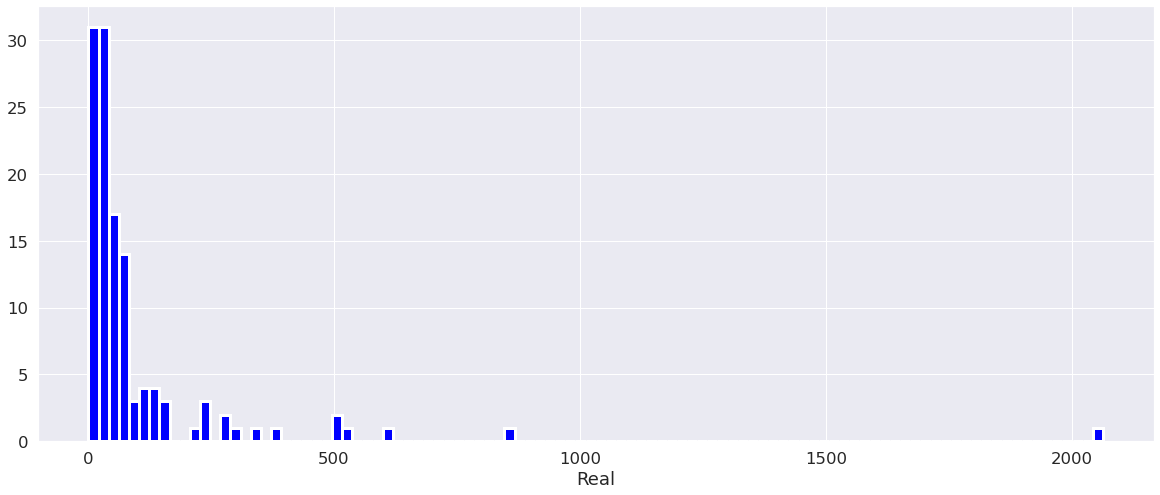

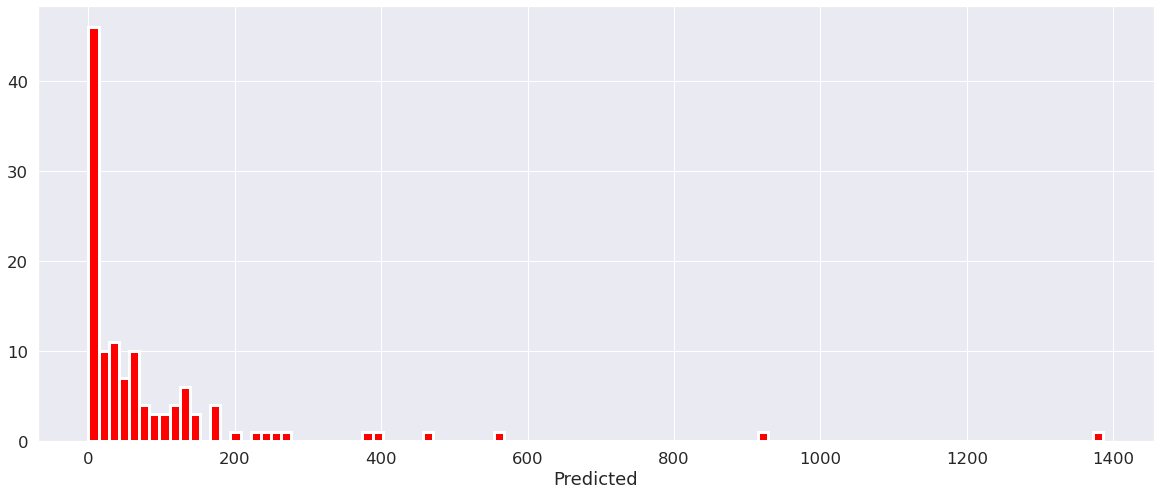


Validating gbm on set 6 and 2017-05
932 121
RMSE : 153.5416
MAPE': 3.4299
MDAPE': 0.7120
MSE: 23575.0248
MAE: 83.8512
R2: 0.6838


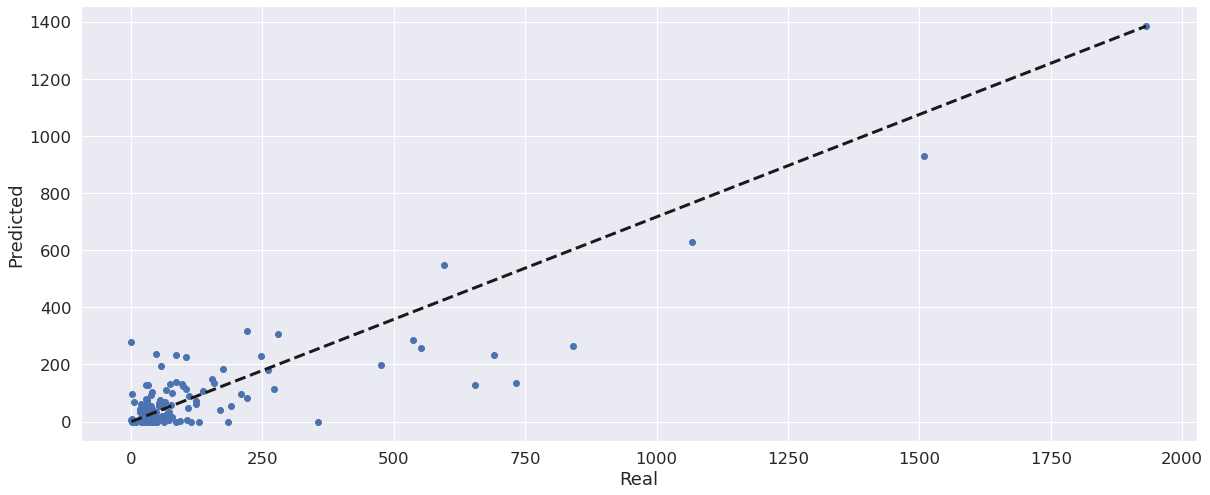

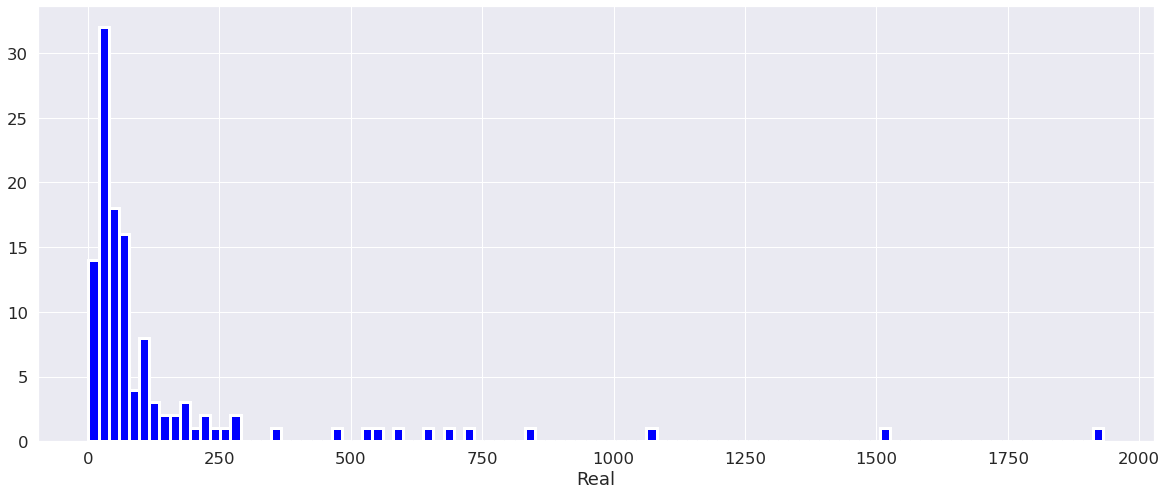

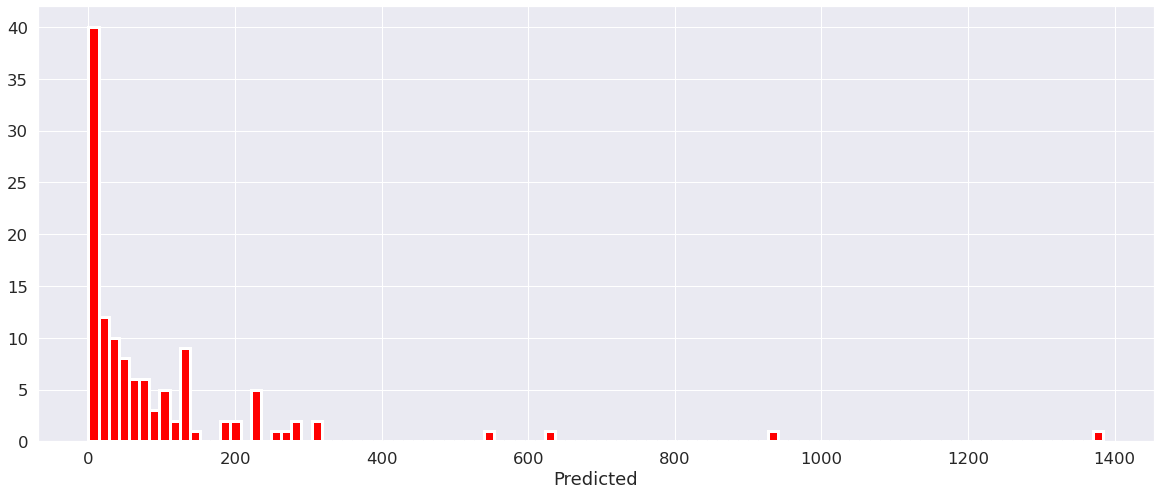


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 133.2366
MAPE': 2.2068
MDAPE': 0.5678
MSE: 17752.0000
MAE: 58.1120
R2: 0.6842


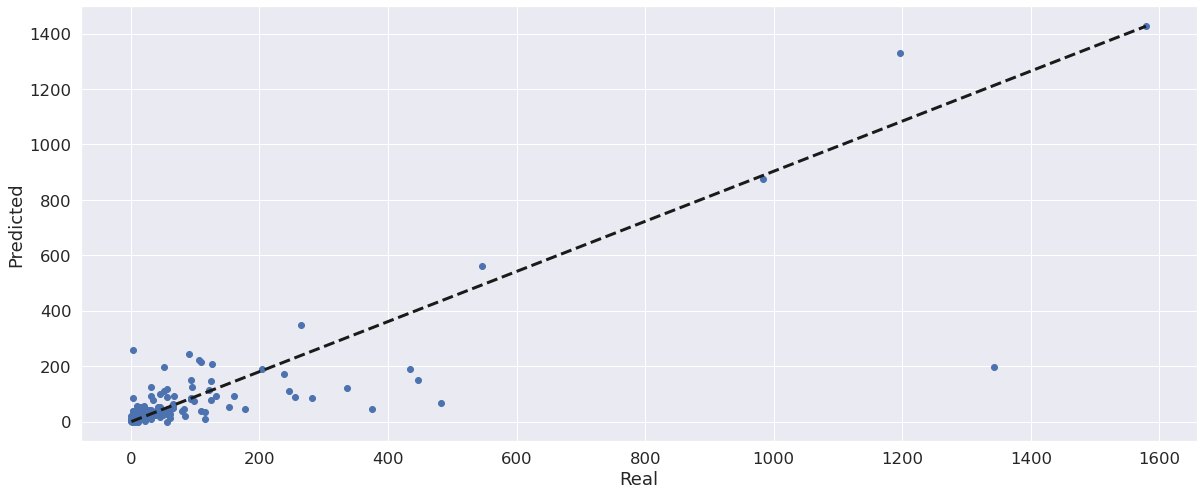

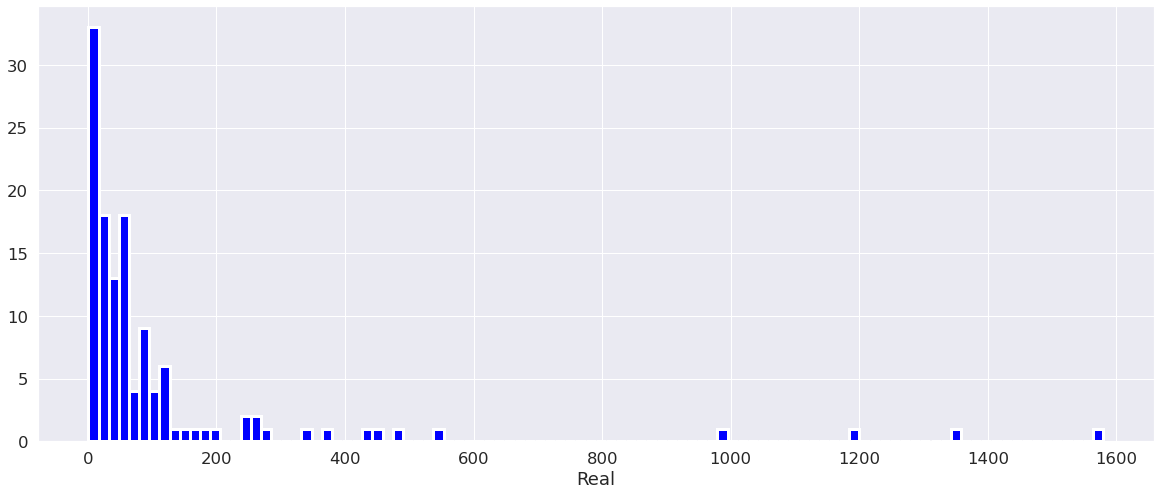

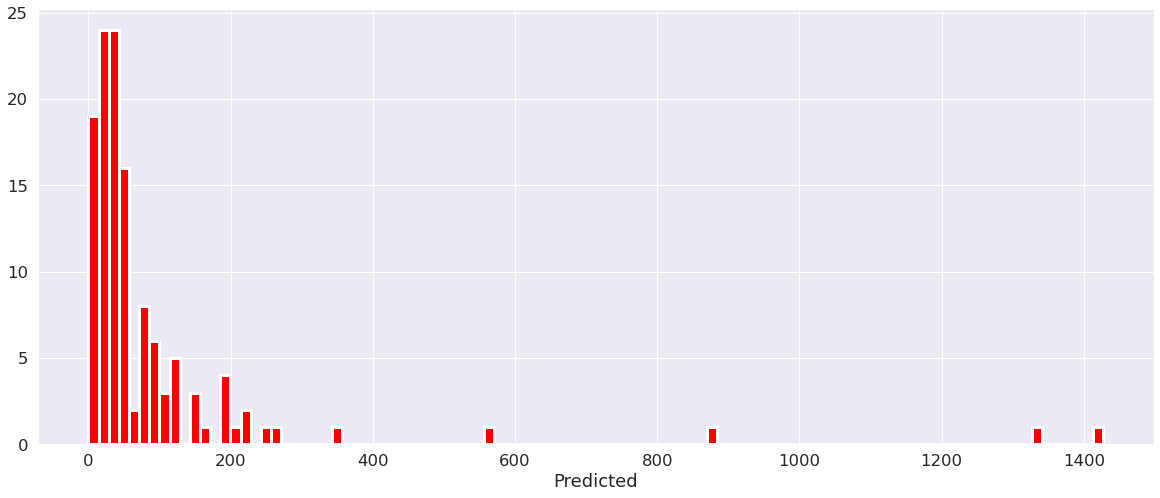


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 123.3034
MAPE': 1.4309
MDAPE': 0.5285
MSE: 15203.7377
MAE: 57.2951
R2: 0.6891


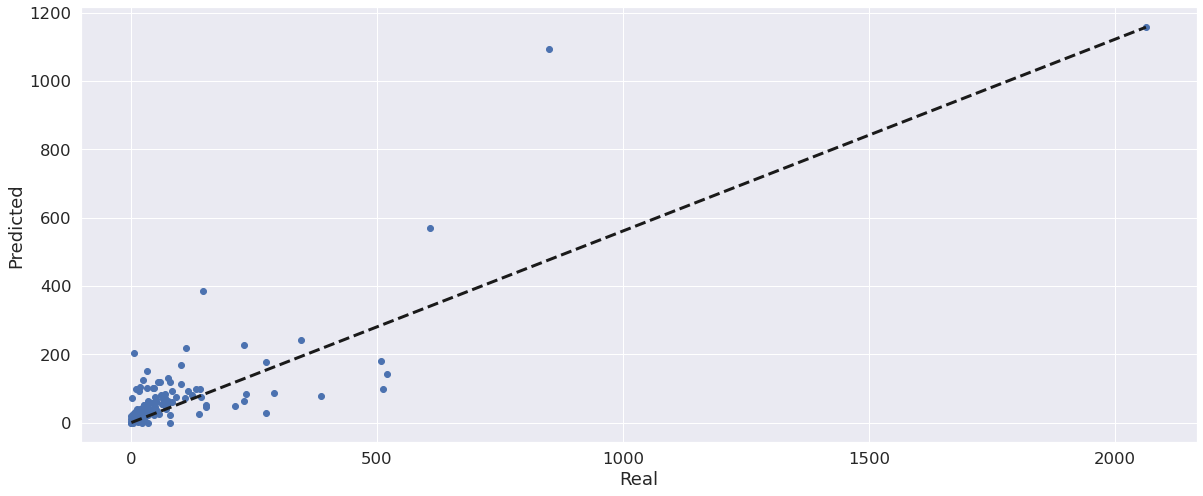

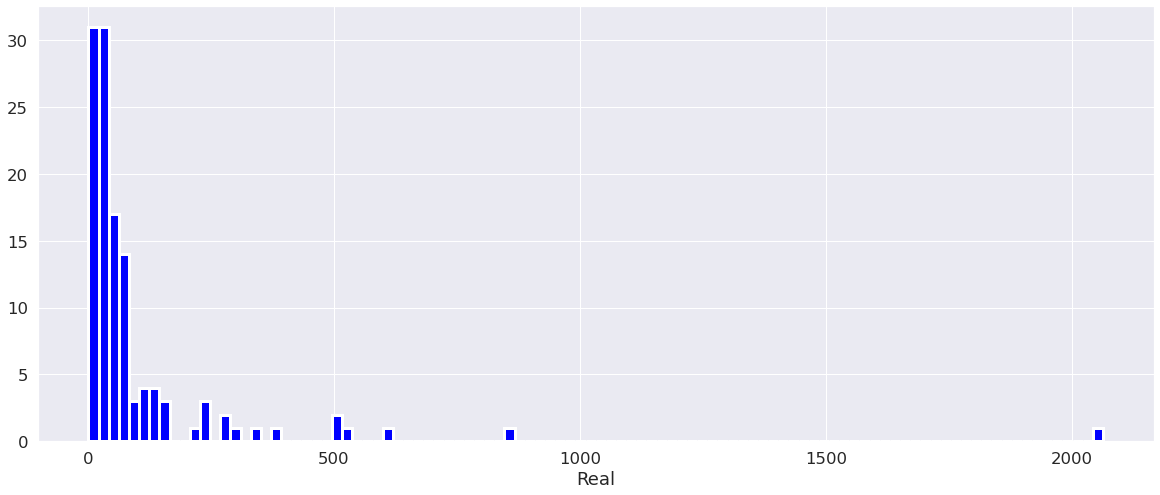

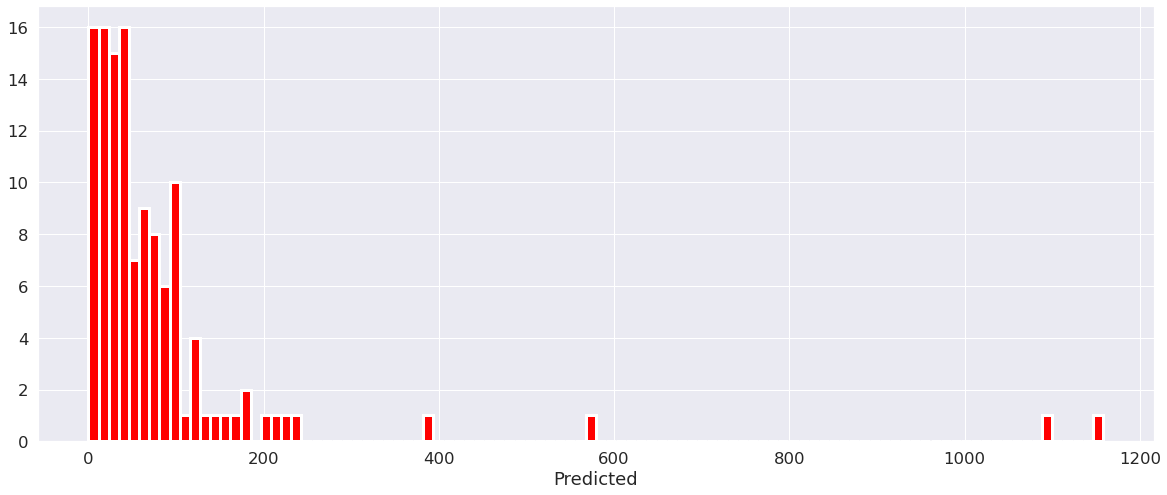


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 160.1978
MAPE': 1.5479
MDAPE': 0.6272
MSE: 25663.3223
MAE: 86.1488
R2: 0.6558


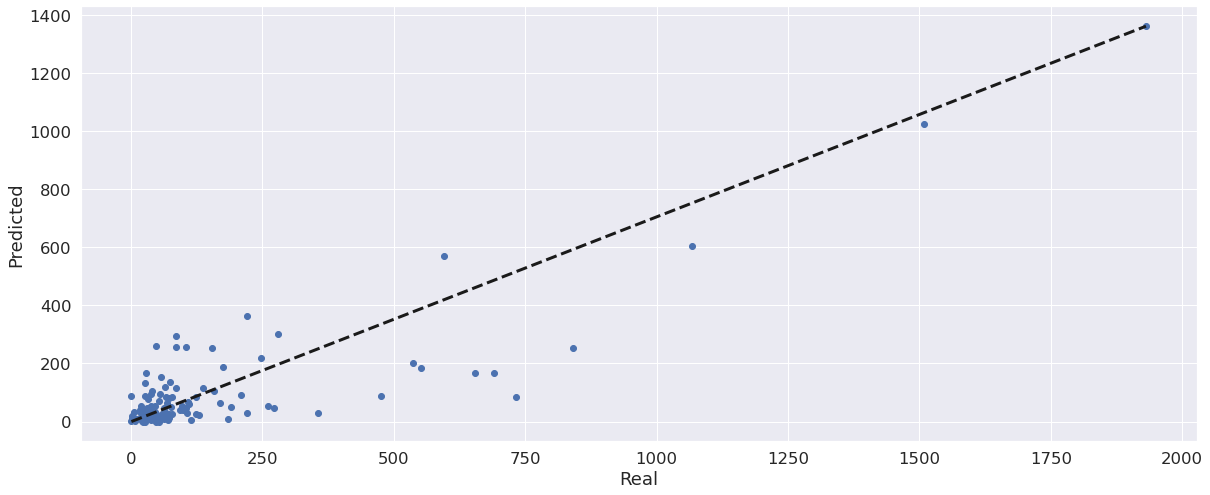

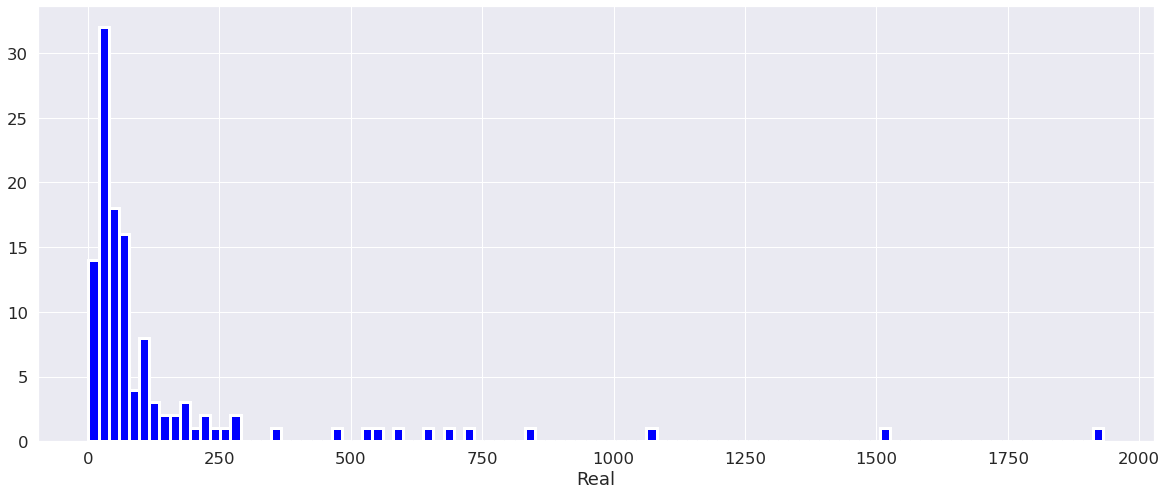

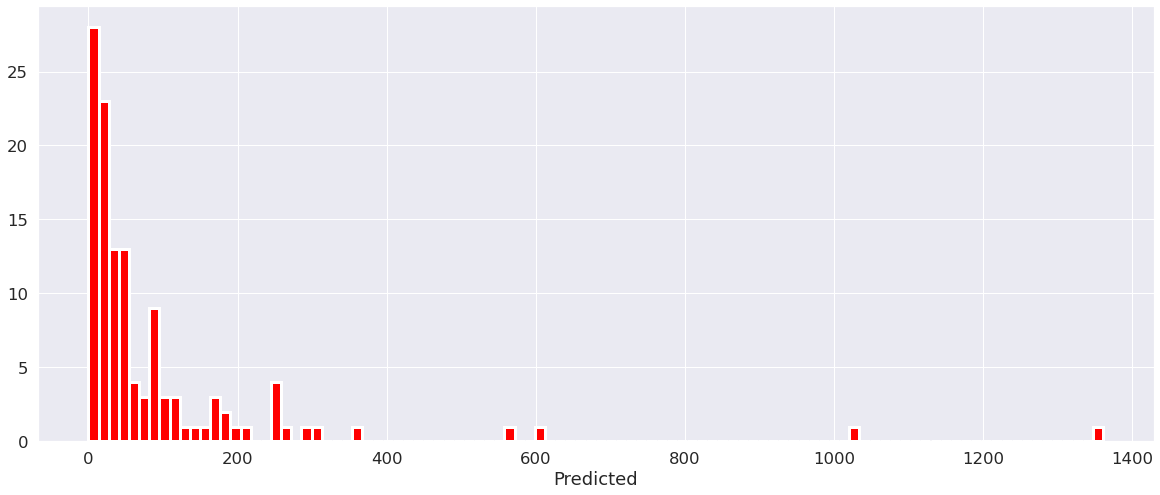

In [30]:
results = []
for r_name, r in r_dict.items():
    s=6
    df_set = df_train_val_test[(df_train_val_test.set == s)]
    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_transformed[df_dataset_transformed.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
      
    r_inst = r.best_estimator_.fit(X=df_train[X_cols], y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_transformed[df_dataset_transformed.year_month == val_year]
        
        print(f'Validating {r_name} on set {s} and {val_year}')
        
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(df_val[X_cols])

        y_pred_val = refining_prediction(y_pred_val)
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [31]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,142.257176,2.216834,0.903946,20237.104000,65.072000,0.639971,"LGBMRegressor(max_depth=9, metric='mape', min_...",gbm,6,2017-03
3,133.236632,2.206800,0.567816,17752.000000,58.112000,0.684182,"LGBMRegressor(alpha=0.5, max_depth=21, metric=...",gbm_q,6,2017-03
1,110.201269,1.769295,0.860029,12144.319672,61.073770,0.751697,"LGBMRegressor(max_depth=9, metric='mape', min_...",gbm,6,2017-04
4,123.303438,1.430930,0.528490,15203.737705,57.295082,0.689144,"LGBMRegressor(alpha=0.5, max_depth=21, metric=...",gbm_q,6,2017-04
2,153.541606,3.429940,0.712042,23575.024793,83.851240,0.683798,"LGBMRegressor(max_depth=9, metric='mape', min_...",gbm,6,2017-05
5,160.197760,1.547859,0.627219,25663.322314,86.148760,0.655788,"LGBMRegressor(alpha=0.5, max_depth=21, metric=...",gbm_q,6,2017-05


## Validation for May

In [32]:
val_years[:2], val_years[2:]

(['2017-03', '2017-04'], ['2017-05'])

Training gbm on set 6
Validating gbm on set 6 and 2017-05
1179 121
RMSE : 146.8981
MAPE': 4.5378
MDAPE': 0.5769
MSE: 21579.0413
MAE: 75.6033
R2: 0.7106


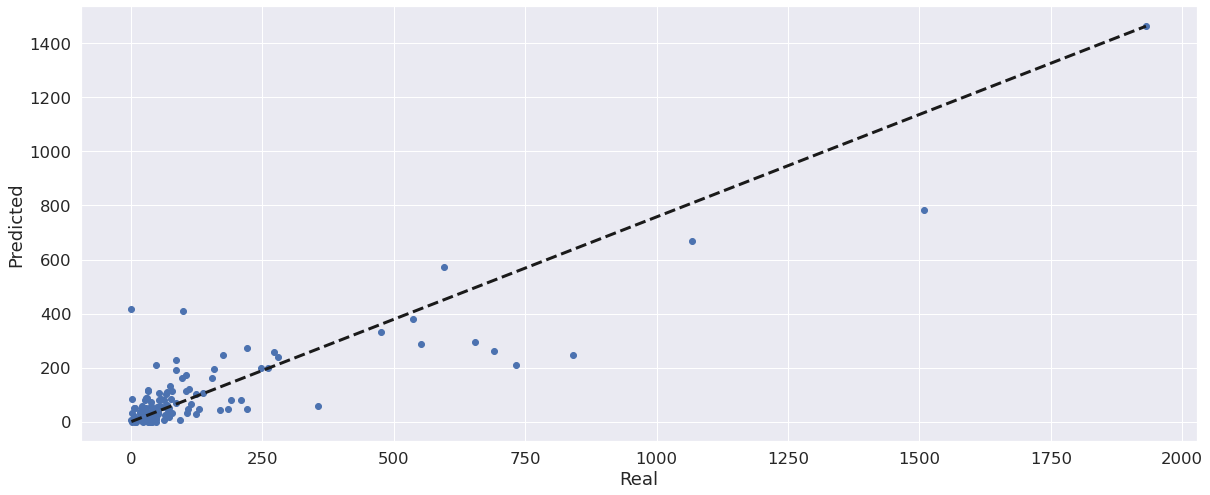

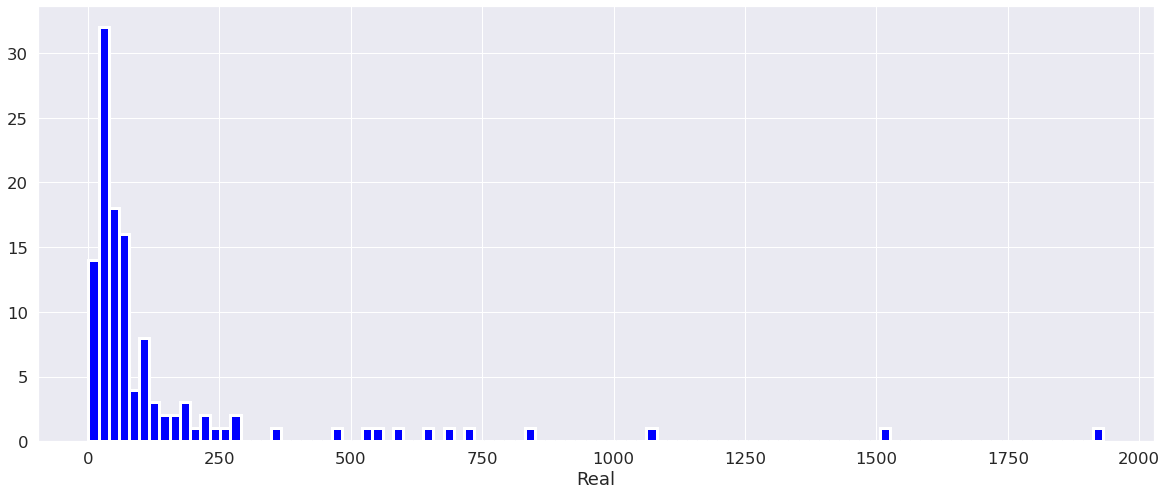

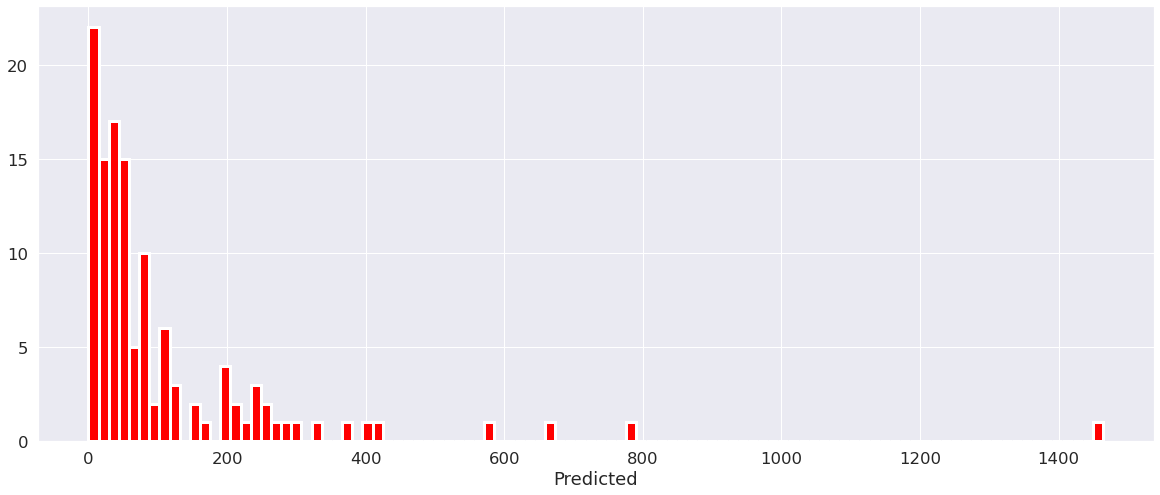


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-05
1179 121
RMSE : 141.0848
MAPE': 0.7760
MDAPE': 0.4015
MSE: 19904.9174
MAE: 65.3306
R2: 0.7330


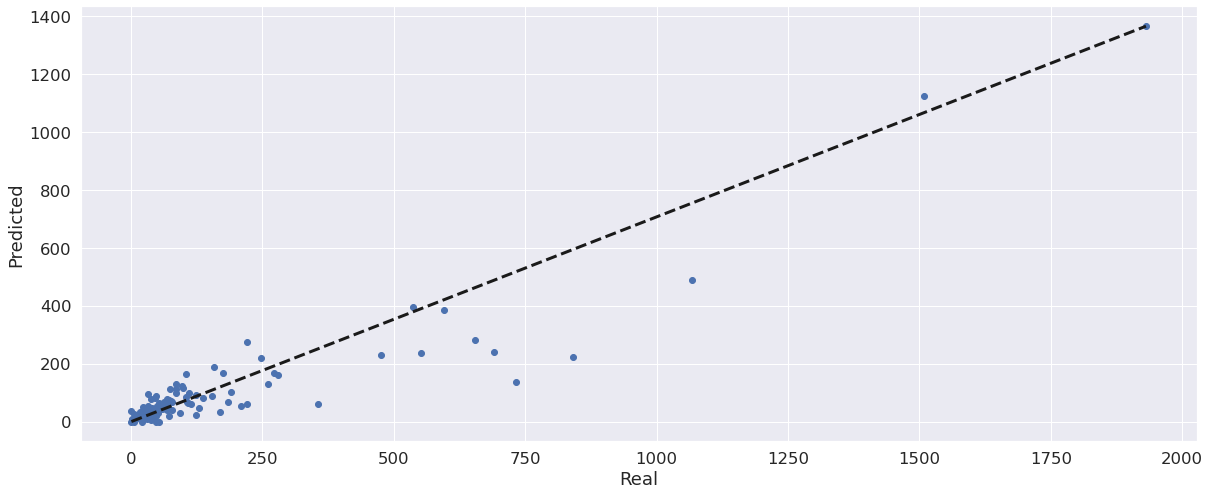

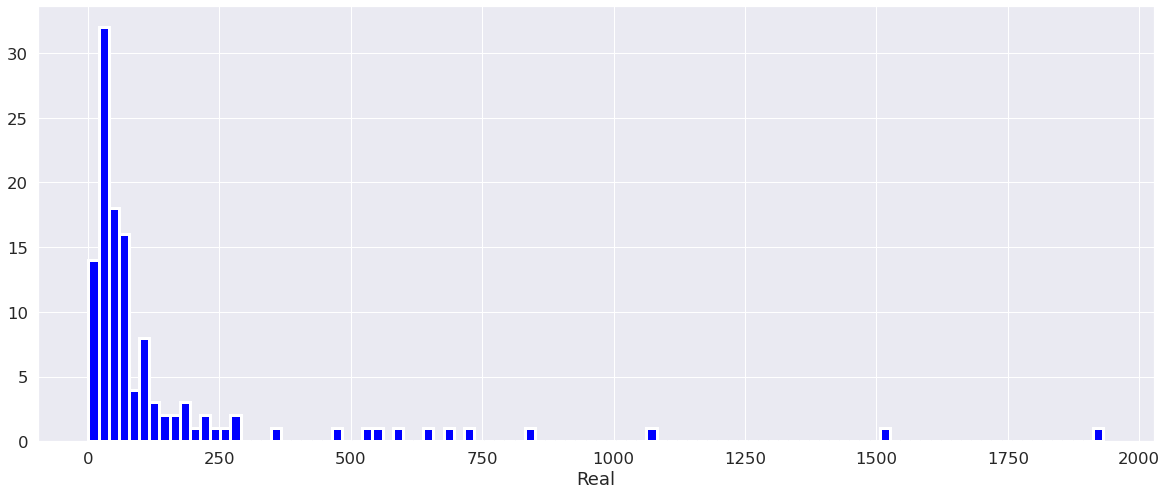

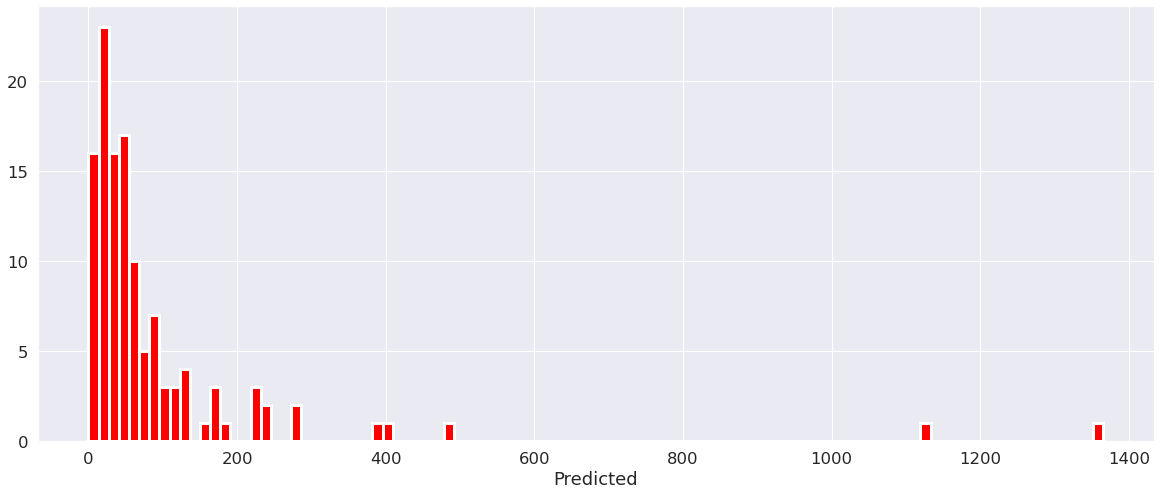

In [33]:
results = []
for r_name, r in r_dict.items():
    s=6
    df_set = df_train_val_test[(df_train_val_test.set == s)]
    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_transformed[df_dataset_transformed.year_month.isin(train_years + val_years[:2])]    

    y_train = df_train['Y'].values    
      
    r_inst = r.best_estimator_.fit(X=df_train[X_cols], y=y_train)
        
    for val_year in val_years[2:]:
        df_val = df_dataset_transformed[df_dataset_transformed.year_month == val_year]
        
        print(f'Validating {r_name} on set {s} and {val_year}')
        
        y_val = df_val['Y']
        y_pred_val = refining_prediction(r_inst.predict(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

## Predict June, August and September

### Retraining on full dataset

In [34]:
final_estimators = {}
for r_name, r in r_dict.items():
    s=6
    df_set = df_train_val_test[(df_train_val_test.set == s)]
    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_transformed[df_dataset_transformed.year_month.isin(train_years + val_years)]    

    y_train = df_train['Y'].values    
      
    final_estimators[r_name] = r.best_estimator_.fit(X=df_train[X_cols], y=y_train)    

Training gbm on set 6
Training gbm_q on set 6


In [35]:
df_feature_importances = pd.DataFrame([df_train[X_cols].columns, final_estimators['gbm_q'].feature_importances_]).T
df_feature_importances.columns = ['feature', 'importance']
df_feature_importances.sort_values('importance', ascending=False)

,feature,importance
2,unit_price,6430
0,code,4756
1,month,2682
3,kmeans_cluster_0,135
8,kmeans_cluster_5,129
7,kmeans_cluster_4,104
4,kmeans_cluster_1,59
9,kmeans_cluster_6,54
13,cat_code_1,47
11,kmeans_cluster_8,34


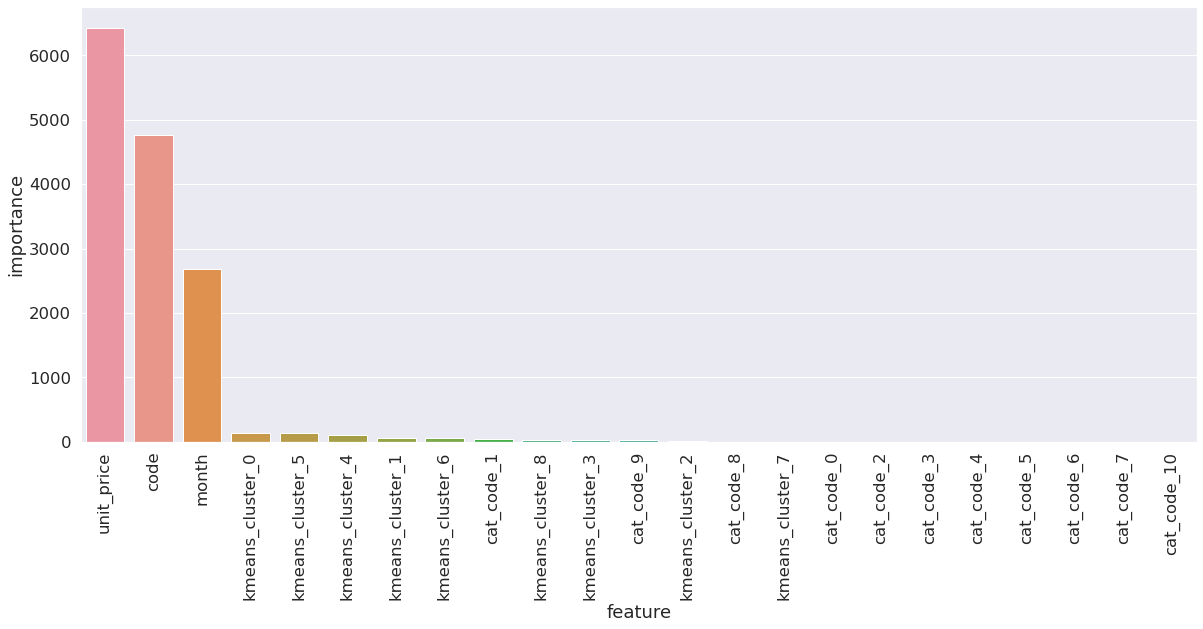

In [36]:
ax = sns.barplot(data=df_feature_importances.sort_values('importance', ascending=False),x='feature', y='importance')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Scenario 1 - Keeping the last Price (2016) + inflation (2017)
https://agenciadenoticias.ibge.gov.br/agencia-noticias/2012-agencia-de-noticias/noticias/19439-inflacao-fecha-2017-em-2-95-e-fica-abaixo-do-piso-da-meta#:~:text=Com%20varia%C3%A7%C3%A3o%20de%200%2C44,ficou%20em%202%2C95%25.

* Some products will be missing the catalog


In [37]:
df_sales_june_july_august = df_dataset_transformed[df_dataset_transformed.year_month.isin(['2016-06', '2016-07', '2016-08'])].copy()
df_sales_june_july_august

,code,year_month,month,unit_price,prod_code,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10,split
7,1,2016-08,8,0.066000,09f544ec2a74c89abeec7b0590fc2d11,58,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25,3,2016-06,6,0.084886,0bbe09e34a11e8e31cf49d6f8df2992d,11,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26,3,2016-07,7,0.085240,0bbe09e34a11e8e31cf49d6f8df2992d,3,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27,3,2016-08,8,0.085539,0bbe09e34a11e8e31cf49d6f8df2992d,21,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
58,7,2016-06,6,0.052994,13b69fd4bf80b95756e3b138c9169a7f,12,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,128,2016-07,7,0.171402,fd84644da59504bd9e9dcb4b6db63bea,56,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1278,128,2016-08,8,0.166402,fd84644da59504bd9e9dcb4b6db63bea,58,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1288,129,2016-06,6,0.107653,ffdad3ddbaf6c76c9bba1b48c51e03c6,64,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1289,129,2016-07,7,0.111636,ffdad3ddbaf6c76c9bba1b48c51e03c6,39,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
df_sales_june_july_august.year_month = df_sales_june_july_august.year_month.apply(lambda x: x.replace('2016', '2017'))
df_sales_june_july_august.unit_price = df_sales_june_july_august.unit_price.apply(lambda x: x * 1.0295)

In [39]:
df_sales_june_july_august

,code,year_month,month,unit_price,prod_code,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10,split
7,1,2017-08,8,0.067947,09f544ec2a74c89abeec7b0590fc2d11,58,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25,3,2017-06,6,0.087390,0bbe09e34a11e8e31cf49d6f8df2992d,11,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26,3,2017-07,7,0.087755,0bbe09e34a11e8e31cf49d6f8df2992d,3,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27,3,2017-08,8,0.088063,0bbe09e34a11e8e31cf49d6f8df2992d,21,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
58,7,2017-06,6,0.054557,13b69fd4bf80b95756e3b138c9169a7f,12,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,128,2017-07,7,0.176459,fd84644da59504bd9e9dcb4b6db63bea,56,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1278,128,2017-08,8,0.171311,fd84644da59504bd9e9dcb4b6db63bea,58,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1288,129,2017-06,6,0.110829,ffdad3ddbaf6c76c9bba1b48c51e03c6,64,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1289,129,2017-07,7,0.114929,ffdad3ddbaf6c76c9bba1b48c51e03c6,39,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [40]:
for r_name, r in final_estimators.items():
    print(f'Predicting {r_name}')
    df_sales_june_july_august[f'y_pred_{r_name}'] = final_estimators[r_name].predict(df_sales_june_july_august[X_cols])

Predicting gbm
Predicting gbm_q


In [41]:
df_sales_june_july_august[['Y', 'y_pred_gbm', 'y_pred_gbm_q']].describe()

,Y,y_pred_gbm,y_pred_gbm_q
count,249.000000,249.000000,249.000000
mean,107.823293,108.231415,98.926456
std,238.425059,219.570326,204.922189
min,1.000000,-111.035145,-38.386067
25%,8.000000,15.508529,15.982946
50%,32.000000,43.691447,34.970463
75%,99.000000,99.246287,83.090501
max,1731.000000,1444.524221,1440.687536


In [42]:
len(df_sales_june_july_august[df_sales_june_july_august['y_pred_gbm'] < 0])

30

In [43]:
len(df_sales_june_july_august[df_sales_june_july_august['y_pred_gbm_q'] < 0])

6

In [44]:
df_sales_june_july_august['y_pred_gbm'] = refining_prediction(df_sales_june_july_august['y_pred_gbm'])
df_sales_june_july_august['y_pred_gbm_q'] = refining_prediction(df_sales_june_july_august['y_pred_gbm_q'])

In [45]:
df_sales_june_july_august[['Y', 'y_pred_gbm', 'y_pred_gbm_q']].describe()

,Y,y_pred_gbm,y_pred_gbm_q
count,249.000000,249.000000,249.000000
mean,107.823293,111.453815,99.136546
std,238.425059,217.550288,204.821434
min,1.000000,0.000000,0.000000
25%,8.000000,16.000000,16.000000
50%,32.000000,44.000000,35.000000
75%,99.000000,99.000000,83.000000
max,1731.000000,1445.000000,1441.000000


In [46]:
df_sales_june_july_august.drop(columns=['Y','y_pred_gbm']).to_csv('../data/output_desafio_exp12.csv')